# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
!pip install tensorflow==2.17.0 scikit-learn==1.3.1 seaborn==0.13.1 matplotlib==3.8.0 numpy==1.25.2 pandas==2.2.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [2]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [3]:
# Read the dataset
images = np.load('images.npy')

# Load the labels file of dataset
labels = pd.read_csv('Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [4]:
print(images.shape)
print(labels.shape)


(4750, 128, 128, 3)
(4750, 1)


Observations:
There are 4750 images and corresponding labels in our data set.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [5]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

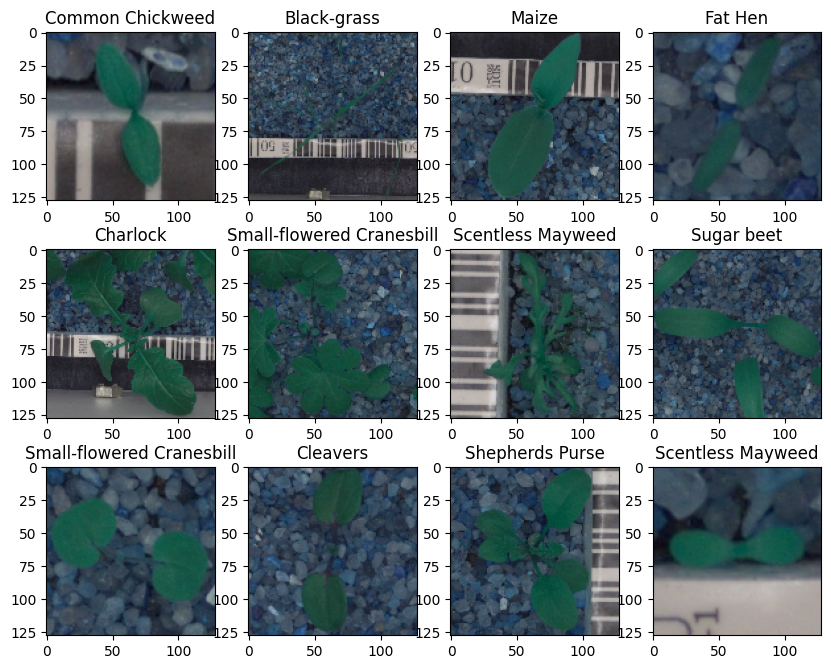

In [6]:
plot_images(images,labels)

Observations:
The above random sampled images show that the images are of size 128 X128.
These images are at different zoom levels.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

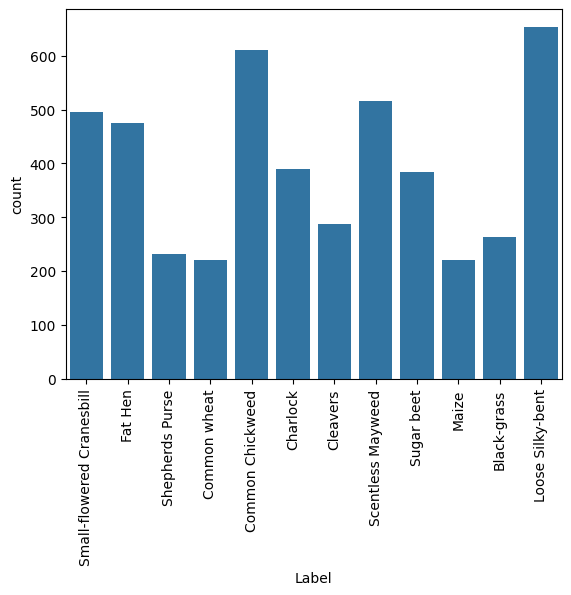

In [7]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

Observations:
1. The data set is not evenly distributed among all the possible labels.
2. there are many more samples for Loose Silky-bent and Common Chickweed.
3. There are very few samples for Common wheat, Maize
4. This imbalance in data sets may impact our predictions.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [8]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [9]:
images_decreased=[]
height = 64
width =  64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

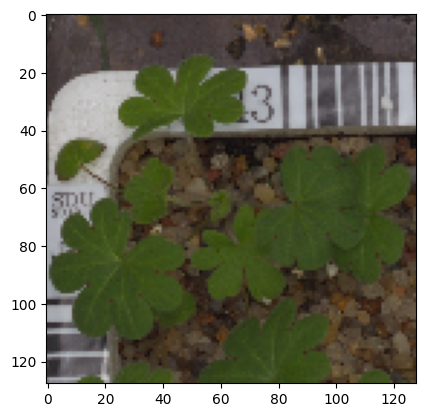

In [10]:
# Display a sample image before the resizing
plt.imshow(images[3])

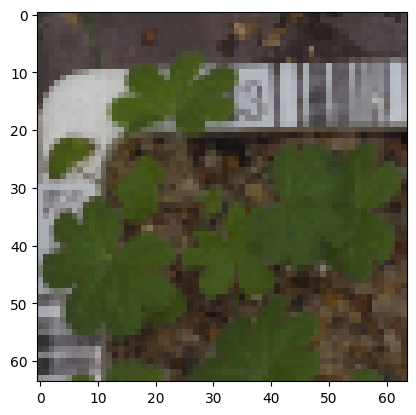

In [11]:
# Display the above image after the resizing
plt.imshow(images_decreased[3])

Observations:
The resize of the images reduced the quality of the image, but the content is still in tact.
This should drastically reduce the model training time.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [12]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels, test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp, test_size=0.1, random_state=42,stratify=y_temp)

In [13]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


First I split the data set between 90% training (temp) and 10% test data.
From the 90% of training data, I split out 10% for validation data set.

### Encode the target labels

In [14]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train['Label'])
y_val_encoded=enc.transform(y_val['Label'])
y_test_encoded=enc.transform(y_test['Label'])

In [15]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

### Data Normalization

In [16]:
# Normalize the pixel values of the image data by dividing by 255.0.
# This scales the pixel values to the range of 0 to 1, which can improve model performance.
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [17]:
backend.clear_session()

In [18]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [19]:
model1 = Sequential()                             # Complete the code to intialize a sequential model

# Add the first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(filters=128,kernel_size= (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Add two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# Add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# Use the Adam Optimizer
opt=Adam()
# Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          32,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,828 (503.23 KB)

 Trainable params: 128,828 (503.23 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 102s - 847ms/step - accuracy: 0.1165 - loss: 2.4592 - val_accuracy: 0.2126 - val_loss: 2.4087
Epoch 2/30
121/121 - 123s - 1s/step - accuracy: 0.2251 - loss: 2.2434 - val_accuracy: 0.3458 - val_loss: 2.0050
Epoch 3/30
121/121 - 87s - 716ms/step - accuracy: 0.3073 - loss: 2.0026 - val_accuracy: 0.3668 - val_loss: 1.7794
Epoch 4/30
121/121 - 79s - 652ms/step - accuracy: 0.3265 - loss: 1.8904 - val_accuracy: 0.3972 - val_loss: 1.6334
Epoch 5/30
121/121 - 83s - 685ms/step - accuracy: 0.3546 - loss: 1.7755 - val_accuracy: 0.4299 - val_loss: 1.5675
Epoch 6/30
121/121 - 82s - 676ms/step - accuracy: 0.3592 - loss: 1.7147 - val_accuracy: 0.4743 - val_loss: 1.4617
Epoch 7/30
121/121 - 82s - 678ms/step - accuracy: 0.3808 - loss: 1.6479 - val_accuracy: 0.4626 - val_loss: 1.4166
Epoch 8/30
121/121 - 81s - 671ms/step - accuracy: 0.3946 - loss: 1.6027 - val_accuracy: 0.5000 - val_loss: 1.3871
Epoch 9/30
121/121 - 82s - 677ms/step - accuracy: 0.4029 - loss: 1.5812 - val_accuracy: 0

MOdel Evaluation

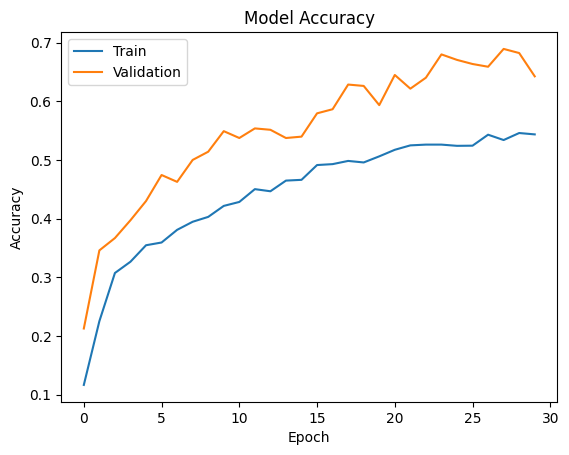

In [21]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
# Evaluate the model on test data
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 2s - 152ms/step - accuracy: 0.6211 - loss: 1.1297


In [23]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step


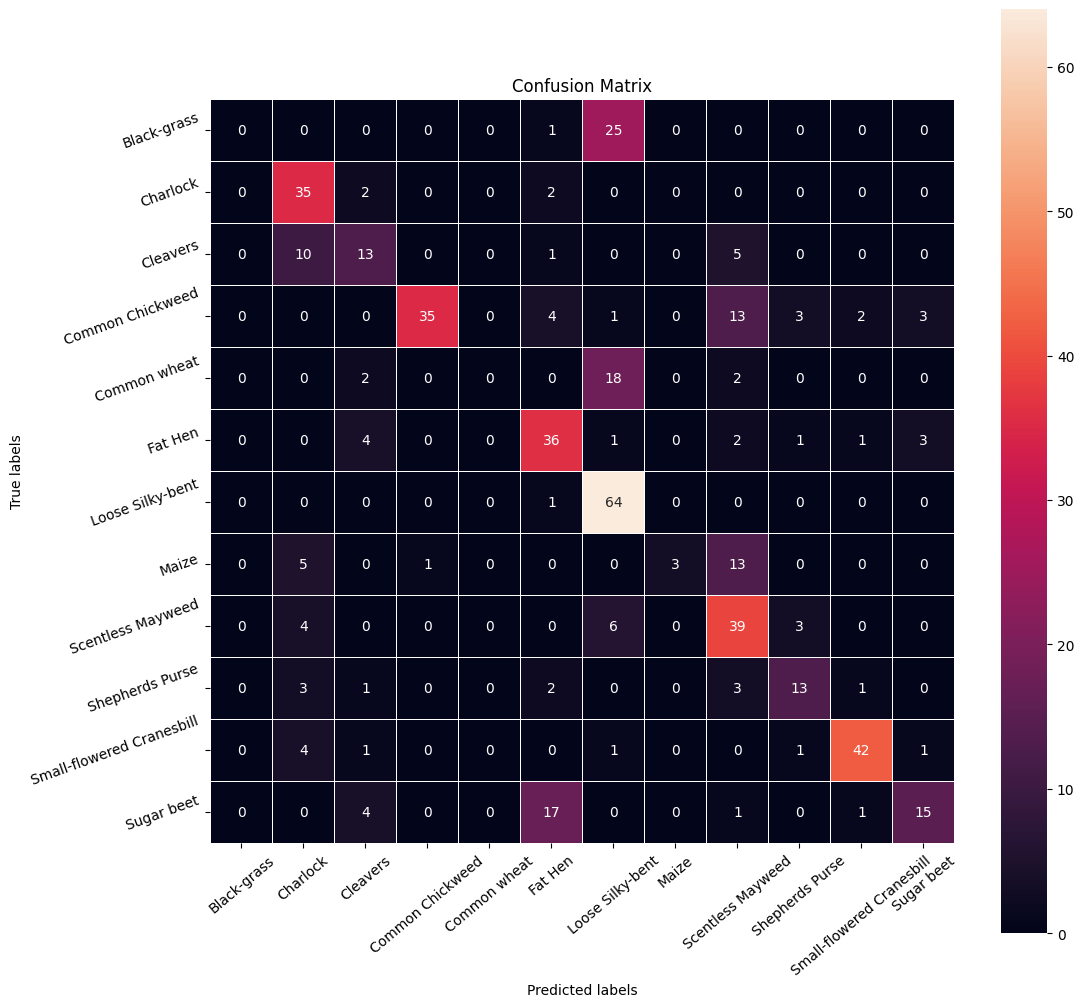

In [24]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)              # Complete the code to plot the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [25]:
# Plotting the classification report
from sklearn import metrics
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.57      0.90      0.70        39
           2       0.48      0.45      0.46        29
           3       0.97      0.57      0.72        61
           4       0.00      0.00      0.00        22
           5       0.56      0.75      0.64        48
           6       0.55      0.98      0.71        65
           7       1.00      0.14      0.24        22
           8       0.50      0.75      0.60        52
           9       0.62      0.57      0.59        23
          10       0.89      0.84      0.87        50
          11       0.68      0.39      0.50        38

    accuracy                           0.62       475
   macro avg       0.57      0.53      0.50       475
weighted avg       0.61      0.62      0.58       475



## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [26]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


In [27]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [28]:
# Set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [29]:
# Intializing a sequential model
model2 = Sequential()

# Add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# Add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Initialize Adam Optimimzer
opt=Adam()
# Complete the code to Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,676 (592.48 KB)

 Trainable params: 151,612 (592.23 KB)

 Non-trainable params: 64 (256.00 B)

In [30]:
# Complete the code to fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 624ms/step - accuracy: 0.1575 - loss: 2.4338 - val_accuracy: 0.3621 - val_loss: 2.4039 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3906 - loss: 1.9921 - val_accuracy: 0.3762 - val_loss: 2.3985 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 649ms/step - accuracy: 0.3620 - loss: 1.9065 - val_accuracy: 0.3762 - val_loss: 2.2899 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5000 - loss: 1.7908 - val_accuracy: 0.3855 - val_loss: 2.3047 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 625ms/step - accuracy: 0.4633 - loss: 1.6681 - val_accuracy: 0.2453 - val_loss: 2.1890 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4844 - loss: 1.6845 - val_accuracy: 0.3061 - val_loss: 2.1952 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.4891 - loss: 1.4930
Ep

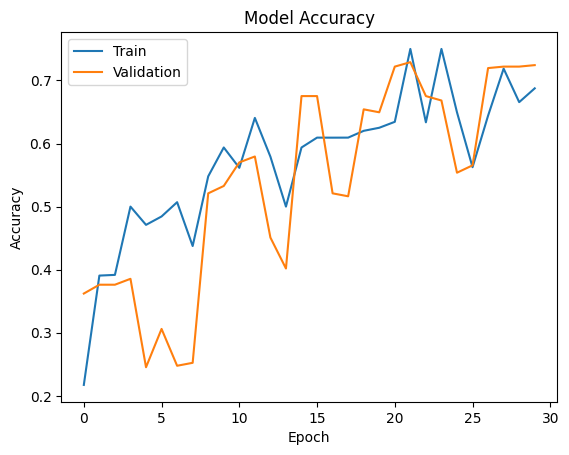

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
# Evaluate the model on test data
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 67ms/step - accuracy: 0.6821 - loss: 0.9022


In [33]:
y_pred=model2.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


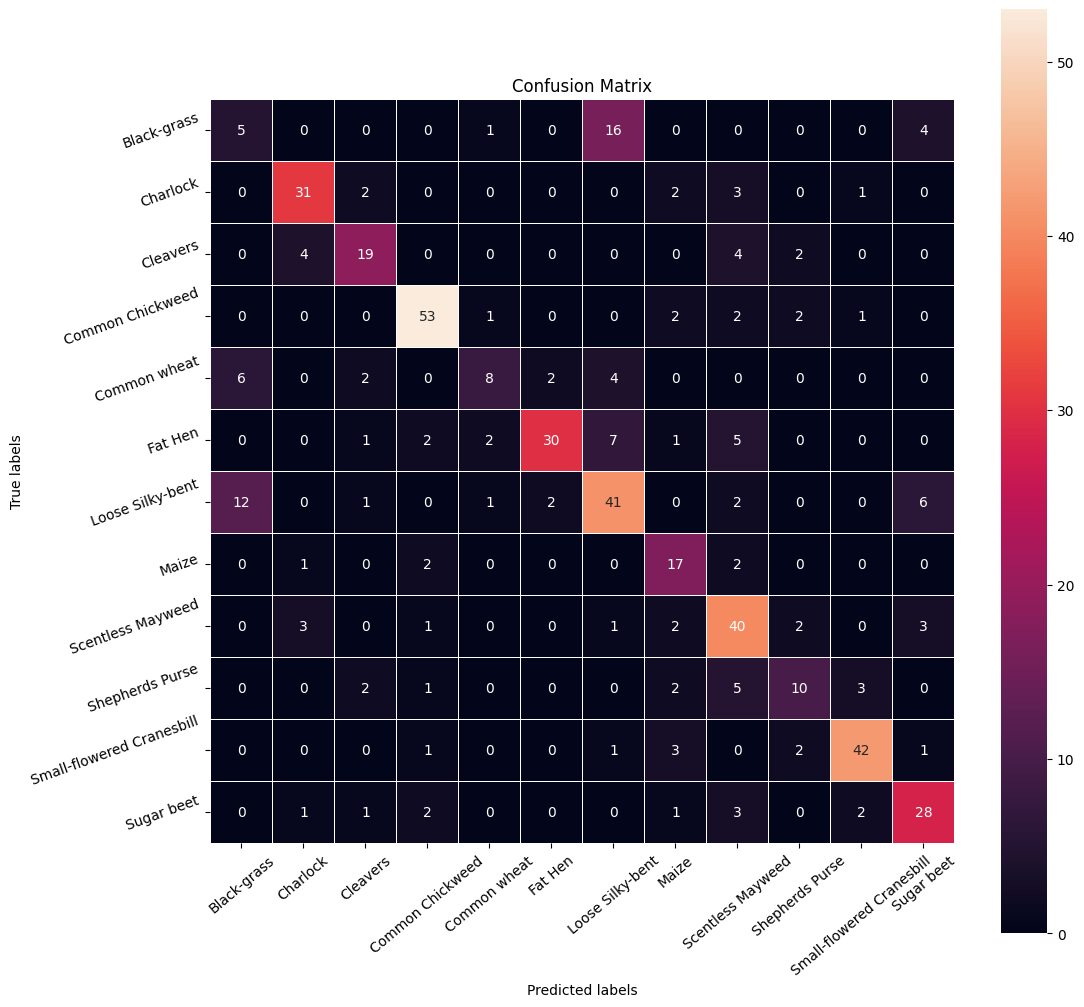

In [34]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [35]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.22      0.19      0.20        26
           1       0.78      0.79      0.78        39
           2       0.68      0.66      0.67        29
           3       0.85      0.87      0.86        61
           4       0.62      0.36      0.46        22
           5       0.88      0.62      0.73        48
           6       0.59      0.63      0.61        65
           7       0.57      0.77      0.65        22
           8       0.61      0.77      0.68        52
           9       0.56      0.43      0.49        23
          10       0.86      0.84      0.85        50
          11       0.67      0.74      0.70        38

    accuracy                           0.68       475
   macro avg       0.66      0.64      0.64       475
weighted avg       0.69      0.68      0.68       475



### Visualizing the prediction

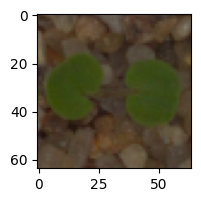

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


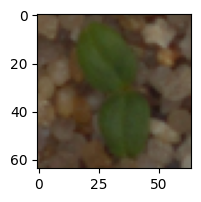

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Label ['Cleavers']
True Label Cleavers


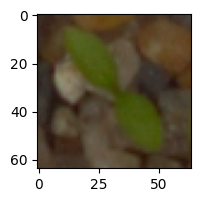

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


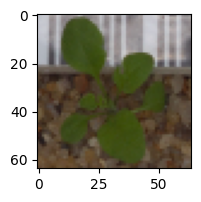

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [36]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations


#### 1. Addressing Class Imbalance
- **Insight**: The dataset reveals a significant class imbalance, with certain plant categories (e.g., Loose Silky-bent, Common Chickweed) significantly outnumbering others (e.g., Common Wheat, Maize).
- **Recommendation**: Employ strategies to mitigate class imbalance:
  - **Data Augmentation**: Enhance under-represented classes by generating synthetic samples through techniques like rotation, flipping, or translation. The existing code includes basic augmentation; however, implementing more advanced methods such as MixUp or CutMix could yield better results.
  - **Class Weights**: Adjust the loss function by assigning greater weights to minority classes during model training. This approach increases the penalty for misclassifications in these categories, which can be effectively implemented in TensorFlow/Keras.
  - **Resampling**: Consider oversampling minority classes or undersampling majority classes to create a more balanced dataset, while being cautious of potential data loss through undersampling.

#### 2. Enhancing Image Quality and Preprocessing
- **Insight**: Resizing images from 128x128 to 64x64 has led to decreased image quality, though key features appear intact.
- **Recommendation**:
  - Experiment with alternative resizing methods or image compression techniques that minimize information loss while reducing computational load. For example, utilize bicubic or Lanczos interpolation instead of linear interpolation.
  - Assess the sufficiency of the reduced resolution for accurate classification. Experimenting with other sizes, such as 96x96 or retaining the original 128x128, may be advantageous if computational resources permit.

#### 3. Optimizing Model Performance
- **Insight**: The current model achieves a satisfactory accuracy level; however, the confusion matrix and classification report indicate deficiencies in accurately classifying certain plant categories. Further analysis is needed to specify numerical weaknesses.
- **Recommendation**:
  - **Hyperparameter Tuning**: Fine-tune key hyperparameters—such as the number of layers, filters, learning rate, dropout rate, and batch size—using methods like GridSearchCV or RandomizedSearchCV. Experimenting with different optimizers, such as SGD with momentum or RMSprop, is also advised.
  
  - **Regularization Techniques**: Strengthen regularization methods, including dropout, to combat overfitting and improve generalization capabilities.

#### 4. Assessing Data Augmentation Effectiveness (Model 2)
- **Insight**: The current implementation of data augmentation through ImageDataGenerator warrants evaluation to determine its effectiveness and potential overfitting issues.
- **Recommendation**:
  - Conduct a detailed analysis of training and validation accuracy curves to identify any signs of overfitting.
  - Adjust augmentation parameters (e.g., rotation_range) or consider integrating more sophisticated augmentation techniques based on the model's weaknesses.

#### 5. Enhancing Visualization and Analysis
- **Insight**: Although the code includes some visualization of predictions, further analysis is essential for understanding misclassification patterns.
- **Recommendation**:
  - Increase the volume of visualized predictions, particularly those that were misclassified, to uncover consistent patterns or characteristics that lead to model difficulties. This process can identify areas for improvement in feature extraction and data preparation.
  - Perform a thorough error analysis to comprehend the reasons behind incorrect predictions for specific categories, guiding subsequent enhancements.

#### 6. Establishing Deployment and Monitoring Strategies
- **Recommendation**: Develop a robust deployment pipeline to make the model accessible to users.
  - Evaluate using TensorFlow Serving or alternative model deployment tools.
  - Implement ongoing monitoring of the model's performance in real-world settings, making periodic evaluations of new data to detect concept drift and ensure ongoing effectiveness. Regular retraining based on this feedback will help maintain the model's reliability and accuracy.

*

_____